In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import os
from scipy.optimize import curve_fit # I want you to use this function for now for regressions.

# Just some parameters for the general aspect of the figures we do
params = {
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'ytick.labelsize' :25,
         'xtick.labelsize' :25,
         'legend.fontsize': 20,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 20
         }
plt.rcParams.update(params)
plt.style.use('default')

# Connecting to Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
(4 * np.pi**2 / (4 * np.sqrt(np.pi) ** 4)) # a good example of numerical errors :), it should be equal to just 1.

np.float64(1.0000000000000002)

In [4]:
# This is going to be the folder where we access the data
data_folder = '/content/drive/My Drive/lab_optique/absorption/data/'
data_folder = 'C:/Users/noedi/Desktop/lab_optique/data/absorption/data/'

# This is going to be the folder where we put the figures
figure_folder = '/content/drive/My Drive/lab_optique/absorption/figures/'
figure_folder = 'C:/Users/noedi/Desktop/lab_optique/data/absorption/figures/'


In [5]:
#line_in_time=lines[8]
#int_time_str = line_in_time.split(" ")[-2]
#int_time=float(int_time_str)


In [6]:
#WE NEED TO DO THIS SHIT FOR MORE CASES, SO LETS MAKE A FONCTION OUT OF THIS
def load_data(fname):
  wavelenghts=[]
  intensities=[]
  with open(fname,"r") as fic:
    lines=fic.readlines()
    line_in_time=lines[8]
    int_time_str = line_in_time.split(" ")[-2]
    int_time=float(int_time_str)*u.micrometer.to(u.meter)
    for line in lines[17:-1]:
      line=line.replace("\t","_")
      line=line.replace("\n","_")
      line=line.replace(",",".")
      ls=line.split("_")
      wavelenght=float(ls[0])
      intensity=float(ls[1])/int_time
      wavelenghts.append(wavelenght)
      intensities.append(intensity)


  wavelenghts=np.array(wavelenghts)
  intensities=np.array(intensities)

  return (wavelenghts,intensities) #put a space after return for some random reason


In [7]:
def get_window(wavelength, intensity, wavelength_center = 589, extent = 50):
    """
    Prendre une tranches (en termes de longueur d'ondes) de données
    """
    idx_center = np.argmin(abs(wavelength - wavelength_center))
    D, U = idx_center - extent, idx_center + extent
    return wavelength[D:U], intensity[D:U]

In [8]:
fname=data_folder+"doublet_sodium_resolution.txt"
wavelenght_full,intensity_full=load_data(fname)
wavelenght,intensity=get_window(wavelenght_full,intensity_full,extent=200)

extent_stat = 170
offset=intensity[:extent_stat].mean() #we are adjusting the baseline of our measurements to zero
std_intensity = intensity[:extent_stat].std(ddof = 1)
intensity=intensity-offset

In [9]:
std_intensity

np.float64(3846.4464168342656)

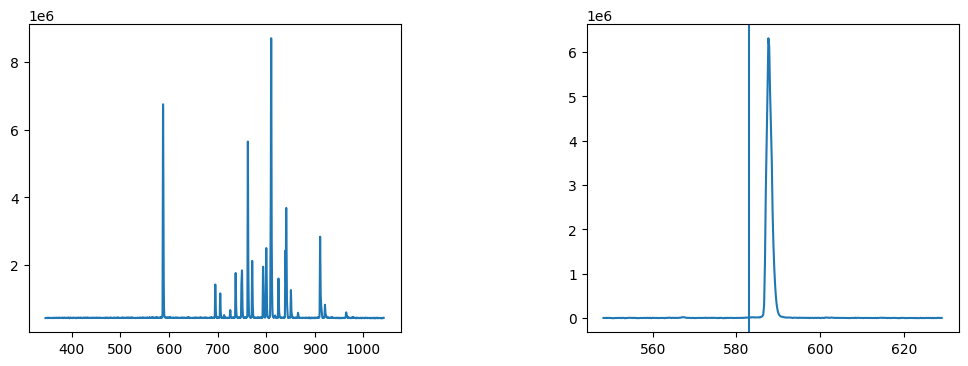

In [10]:

#we are gonna plot them now
#plt.plot(wavelenghts,intensities)
fig,axes=plt.subplots(1,2,figsize=(12,4))
ax=axes[0]
ax.plot(wavelenght_full,intensity_full)
ax=axes[1]
ax.plot(wavelenght,intensity)
ax.axvline(wavelenght[extent_stat])
plt.subplots_adjust(wspace=0.5)

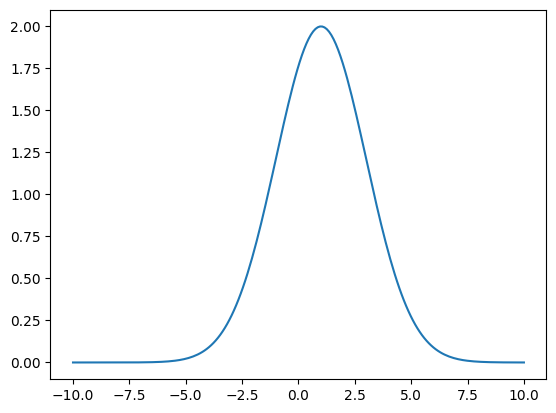

In [11]:
def gaussian(x,mean,sigma,I0):
  y=I0*np.exp(-(x-mean)**2/(2*sigma**2))
  return y

x=np.linspace(-10,10,200)
mean=1
sigma=2
I0=2

plt.plot(x,gaussian(x,mean,sigma,I0))


In [12]:
params_fitted,cov=curve_fit(f=gaussian,xdata=wavelenght,ydata=intensity,p0=(589,1,1e6), sigma = std_intensity)
uncertainty=np.sqrt(np.diag(cov))

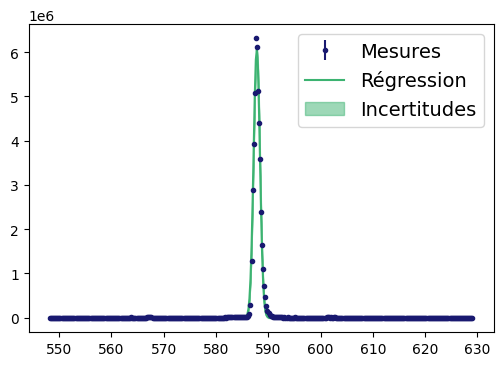

In [13]:
#lazy option for when we don't have time for propagation of errors
fig,ax=plt.subplots(1,1,figsize=(6,4))
y_pred=gaussian(wavelenght,*params_fitted)
k=1
params_min=params_fitted-k*uncertainty
params_max=params_fitted+k*uncertainty
ymin=gaussian(wavelenght,*params_min)
ymax=gaussian(wavelenght,*params_max)
ax.fill_between(wavelenght,
                ymin - k * std_intensity, # this is very wrong
                ymax + k * std_intensity,
                alpha=0.5,
                color="mediumseagreen",
                label="Incertitudes"
                )
k = 3
ax.fill_between(wavelenght,
                ymin - k * std_intensity, # this is very wrong
                ymin + k * std_intensity,
                alpha=0.3,
                color="mediumseagreen"
                )
ax.errorbar(wavelenght, intensity, fmt="." , xerr = None, yerr = std_intensity, color="midnightblue",label="Mesures")
ax.plot(wavelenght,y_pred,color="mediumseagreen",label="Régression")
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=14,loc = "upper right")

To do next for the figure above:
- Zoom in on the bell part of the curve,
- Figure out the good uncertainties,
- Put the two uncertainty zones (68 and 95)%
- Change the text font style.
- Two asymptots for the theoretical values of the doublet ?


## Part 2: Semi-conducteur, Energie *gap*

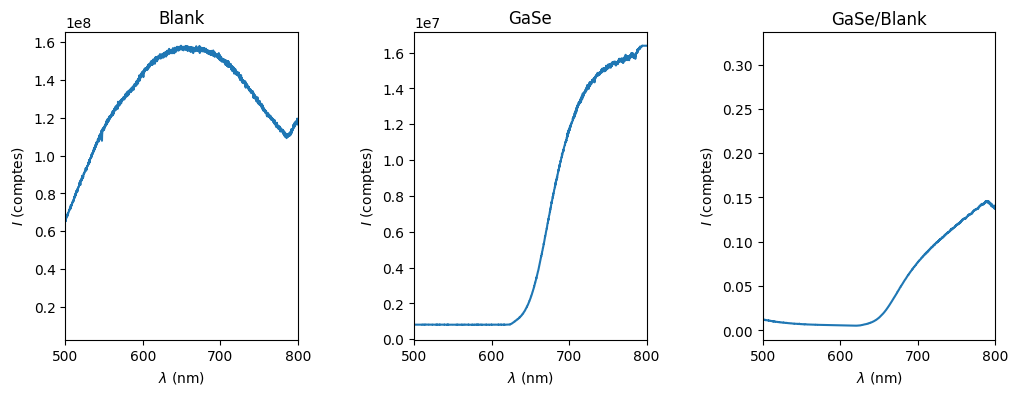

In [14]:
fbname=data_folder+"blank GaSe.txt"
fname=data_folder+"gase_sc.txt"

#writting our file data in the variables

wavelenghtb,intensityb=load_data(fbname)
wavelenght,intensity=load_data(fname)
intensityt=intensity/intensityb

#plotting them

fig,axes=plt.subplots(1,3,figsize=(12,4))
ax=axes[0]
ax.plot(wavelenghtb,intensityb)
ax.set(title="Blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[500,800])

ax=axes[1]
ax.plot(wavelenght,intensity)
ax.set(title="GaSe",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[500,800])

ax=axes[2]
ax.plot(wavelenght,intensityt)
ax.set(title="GaSe/Blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[500,800])



plt.subplots_adjust(wspace=0.5)



(3,)

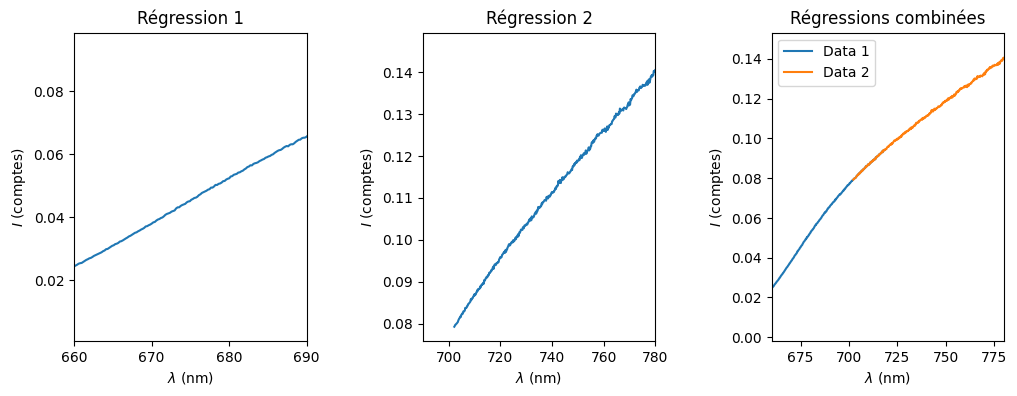

In [15]:
wavelenght1,intensity1=get_window(wavelenght,intensityt,wavelength_center=670,extent=250)
wavelenght2,intensity2=get_window(wavelenght,intensityt,wavelength_center=750,extent=250)

#after getting the desired range we plot it to check

fig,axes=plt.subplots(1,3,figsize=(12,4))
ax=axes[0]
ax.plot(wavelenght1,intensity1)
ax.set(title="Régression 1",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[660,690])

ax=axes[1]
ax.plot(wavelenght2,intensity2)
ax.set(title="Régression 2",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[690,780])

ax = axes[2]
ax.plot(wavelenght1,intensity1,label="Data 1")
ax.plot(wavelenght2,intensity2,label="Data 2")
ax.set(title="Régressions combinées",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[660,780])
ax.legend(loc="upper left")

plt.subplots_adjust(wspace=0.5)


params_fitted.shape


array([ 0.00143592, -0.92390679])

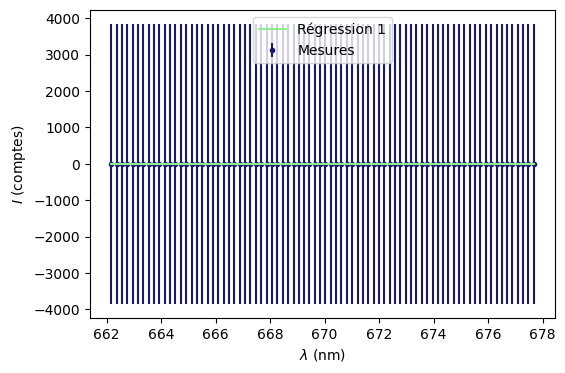

In [16]:
#now we fit first regression
def linear(x,a=5,b=9):
  return (a*x+b)


wavelenght1,intensity1=get_window(wavelenght,intensityt,wavelength_center=670,extent=40)
wavelenght2,intensity2=get_window(wavelenght,intensityt,wavelength_center=750,extent=90)

params_fitted,cov=curve_fit(f=linear,xdata=wavelenght1,ydata=intensity1)


fig,axes=plt.subplots(1,1,figsize=(6,4))
ax=axes
ax.errorbar(wavelenght1,intensity1,xerr=None,yerr=std_intensity,fmt=".",label="Mesures",color="midnightblue",zorder=1)
ypred=linear(wavelenght1,*params_fitted)
ax.plot(wavelenght1,ypred,label="Régression 1",color="lightgreen", zorder=2)
ax.set(xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)")
ax.legend(loc="upper center")
std_intensity = 1e-3

params_fitted

array([ 0.00073584, -0.4332129 ])

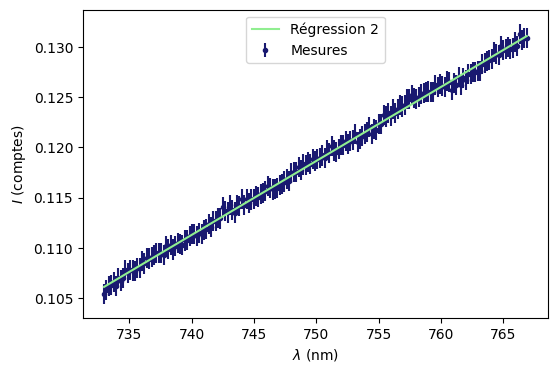

In [17]:
params_fitted,cov=curve_fit(f=linear,xdata=wavelenght2,ydata=intensity2)


fig,axes=plt.subplots(1,1,figsize=(6,4))
ax=axes
ax.errorbar(wavelenght2,intensity2,xerr=None,yerr=std_intensity,fmt=".",label="Mesures",color="midnightblue",zorder=1)
ypred=linear(wavelenght2,*params_fitted)
ax.plot(wavelenght2,ypred,label="Régression 2",color="lightgreen", zorder=2)
ax.set(xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)")
ax.legend(loc="upper center")
std_intensity = 1e-3
params_fitted

(660.0, 780.0)

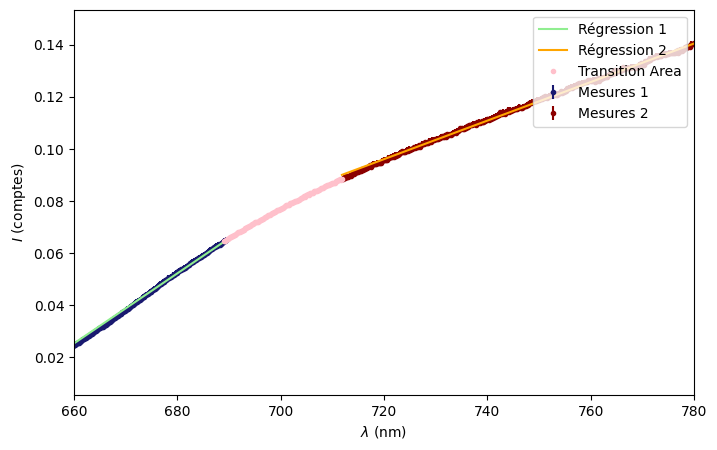

In [18]:
#adjusting the range to put them together


wavelenght1,intensity1=get_window(wavelenght,intensityt,wavelength_center=670,extent=100)
wavelenght2,intensity2=get_window(wavelenght,intensityt,wavelength_center=750,extent=200)

#lets try to put them all in the same figure

params_fitted1,cov1=curve_fit(linear,wavelenght1,intensity1)

params_fitted2,cov2=curve_fit(linear,wavelenght2,intensity2)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# First regression
ax.errorbar(wavelenght1,intensity1,xerr=None,yerr=std_intensity,fmt=".",label="Mesures 1",color="midnightblue",zorder=1)
ypred1=linear(wavelenght1,*params_fitted1)
ax.plot(wavelenght1,ypred1,label="Régression 1",color="lightgreen",zorder=2)

# Second regression
ax.errorbar(wavelenght2,intensity2,xerr=None,yerr=std_intensity,fmt=".",label="Mesures 2",color="darkred",zorder=1)
ypred2=linear(wavelenght2,*params_fitted2)
ax.plot(wavelenght2,ypred2,label="Régression 2",color="orange",zorder=2)

#transition area
mask = (wavelenght >= 689) & (wavelenght <= 712)
ax.plot(wavelenght[mask], intensityt[mask],".",color="pink",label="Transition Area")

# Set labels, limits, and legend
ax.set(xlabel=r"$\lambda$ (nm)", ylabel=r"$I$ (comptes)")
ax.legend(loc="upper right")
ax.set_xlim([660, 780])



## Part 3: Densité électronique de l'or

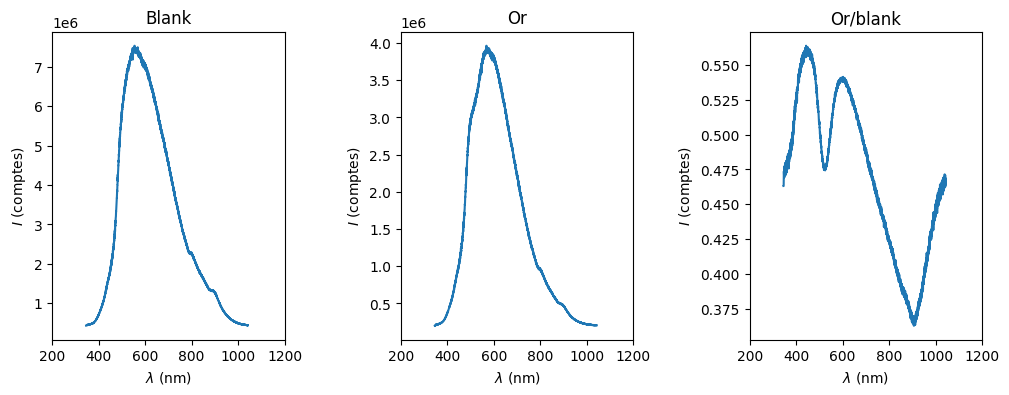

In [19]:
fblank=data_folder+"blank_or.txt"
fdensity=data_folder+"or_density.txt"

#writting our file data in the variables

wavelenghtb,intensityb=load_data(fblank)
wavelenght_raw_out,intensity_raw_out=load_data(fdensity)
wavelenght_processed, intensity_processed = wavelenght_raw_out, intensity_raw_out / intensityb

#plotting them
xmin=200
xmax=1200

fig,axes=plt.subplots(1,3,figsize=(12,4))
ax=axes[0]
ax.plot(wavelenghtb,intensityb)
ax.set(title="Blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])

ax=axes[1]
ax.plot(wavelenght_raw_out,intensity_raw_out)
ax.set(title="Or",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])

ax=axes[2]
ax.plot(wavelenght_processed,intensity_processed)
ax.set(title="Or/blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])

plt.subplots_adjust(wspace=0.5)






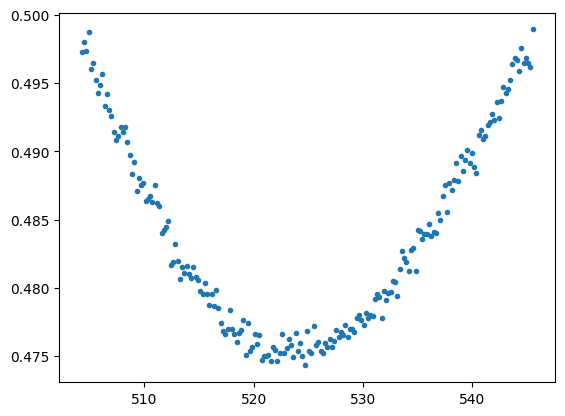

In [20]:
#fitting a parabole in the range we want
wavelenght,intensity=get_window(wavelenght_processed,intensity_processed,wavelength_center=525,extent=100)
plt.plot(wavelenght,intensity,".")
std_intensity = 1e-3


Définition de la fonction a fit

$$
f(x,a,b,c)=ax^2+bx+c
$$

Coordonnée $x$ du minimum
$$
2ax_0+ b=0 \quad x_0=-\frac{b}{2a}
$$

In [56]:
def parabola(x, a, b, c):
  return a*x**2+b*x+c

params_fitted,cov=curve_fit(f=parabola,xdata=wavelenght,ydata=intensity)


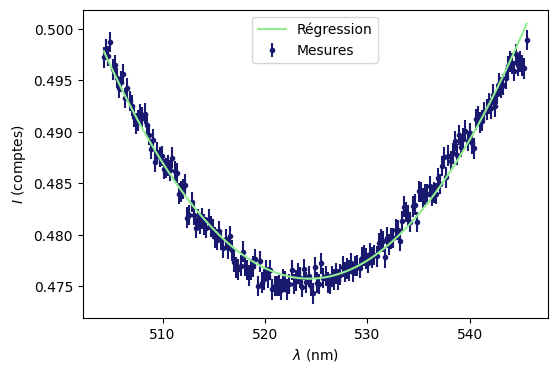

In [57]:
fig,axes=plt.subplots(1,1,figsize=(6,4))
ax=axes
ax.errorbar(wavelenght,intensity,xerr=None,yerr=std_intensity,fmt=".",label="Mesures",color="midnightblue", zorder=1)
ypred=parabola(wavelenght,*params_fitted)
ax.plot(wavelenght,ypred,label="Régression",color="lightgreen", zorder=2)
ax.set(xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)")
ax.legend(loc="upper center")

Maintenant, on va calculer le minimum de cette parabole pour trouver la longueur d'onde correspondante. Cette $\lambda$ correspond à celle de la fréquence
$$
f_p=\frac{1}{2\pi}\sqrt{\frac{ne^2}{m\epsilon_0}}
$$

sachant que

$$
f=c/\lambda
$$
où c est la vitesse de la lumière.

In [58]:
print(params_fitted)
a=params_fitted[0]
b=params_fitted[1]
lambda_p=(-b/(2*a))*1e-9
c=3e8
fp=c/lambda_p
lambda_p

[ 5.49653325e-05 -5.76386728e-02  1.55862644e+01]


np.float64(5.2431842246849e-07)

In [59]:
m=9e-31
epsilon=8.854187e-12
e=1.602176e-19
n=(m*epsilon*(fp*2*np.pi)**2)/e**2
n

np.float64(4.0122017879852507e+27)

## Part 4: Couches minces

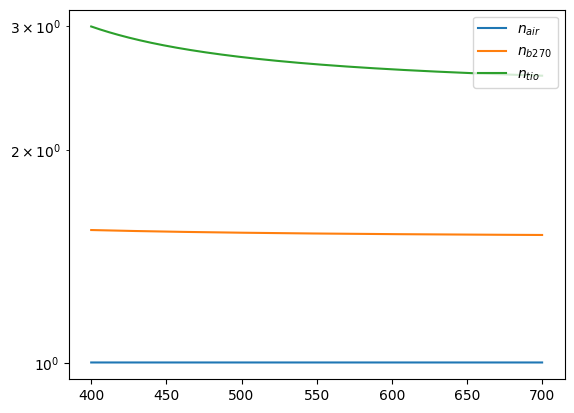

In [70]:

def n_air(wavelength):
    wavelength=wavelength * u.nanometer.to(u.micrometer)
    a1=0.05792105
    a2=238.0185
    b1=0.00167917
    b2=57.362
    n=1+a1/(a2-wavelength**(-2))+b1/(b2-wavelength**(-2))
    return n

def n_b270(wavelength):
    wavelength=wavelength
    a1=1.676
    a2=99.19
    b1=0.3728
    b2=6.359
    c1=0.2172
    c2=6.436
    A=a1*wavelength**2/(wavelength**2-a2**2)
    B=b1*wavelength**2/(wavelength**2-b2**2)
    C=c1*wavelength**2/(wavelength**2-c2**2)
    n=A+B+C
    return n**0.5

def n_tio(wavelength):
  wavelength=wavelength*u.nanometer.to(u.micrometer)
  a=5.913
  b=0.2441
  c=0.0803
  n=a+b/(wavelength**2-0.0803)
  return n**0.5

wavelength=np.linspace(400,700,int(1e4))
plt.plot(wavelength,n_air(wavelength),label=r"$n_{air}$")
plt.plot(wavelength,n_b270(wavelength),label=r"$n_{b270}$")
plt.plot(wavelength,n_tio(wavelength),label=r"$n_{tio}$")

plt.yscale("log")
plt.legend(loc="upper right")



### Coding the equations we need 

In [188]:
def compute_r_i(n_i, n_j): 
    """
    Calcul le coefficient de réflexion:
        - n_i = indice de réfraction du milieu i
        - n_j = indice de réfraction du milie j = i + 1
    """
    return (n_i - n_j) / (n_i + n_j)

def compute_t_i(n_i, n_j): 
    """
    Calcul le coefficient de transmission:
        - n_i = indice de réfraction du milieu i
        - n_j = indice de réfraction du milie j = i + 1
    """
    return 2 * n_i / (n_i + n_j)

def compute_delta(wavelength, d_i, n_i): 
    assert len(n_i) == len(wavelength)
    return 4 * np.pi * d_i * n_i / wavelength

def build_T(wavelength, d_i, n_i, n_j): 
    N = len(wavelength)
    assert len(n_i) == N
    delta = compute_delta(wavelength, d_i, n_i)
    print(delta)
    a = np.cos(delta) - 1j * np.sin(delta) # forme trigo pour pas avoir d'overflow
    b = np.cos(delta) + 1j * np.sin(delta)

    T = np.zeros(shape = (N, 2, 2), dtype = np.complex64)
    T[:, 0, 0] = a
    T[:, 1, 1] = b
    return T
    
def build_I(wavelength, d_i, n_i, n_j):
    N = len(wavelength)
    assert len(n_i) == N
    assert len(n_j) == N 

    r_i = compute_r_i(n_i = n_i, n_j = n_j)
    t_i = compute_t_i(n_i = n_i, n_j = n_j)

    I = np.empty(shape = (N, 2, 2), dtype = np.complex64)
    I[:, 0, 0] = 1 / t_i
    I[:, 0, 1] = r_i / t_i
    I[:, 1, 0] = r_i / t_i
    I[:, 1, 1] = 1 / t_i
    return I

d_0 = 0 # we don't need this
d_1 = 1e-6
d_2 = 1e-6
params_0 = (wavelength * 1e-9, d_0, n_air(wavelength), n_tio(wavelength))
params_1 = (wavelength * 1e-9, d_1, n_tio(wavelength), n_b270(wavelength))
params_2 = (wavelength * 1e-9, d_2, n_b270(wavelength), n_b270(wavelength))

I0 = build_I(*params_0)
T1 = build_T(*params_1)
I1 = build_I(*params_1)
T2 = build_T(*params_2)

E_k = np.array([
    [1], 
    [0]
], dtype = np.complex64)[np.newaxis, ...]

M = I0 @ T1 @ I1 @ T2

E_0 = M @ E_k
E_0_plus = E_0[:, 0, 0]

t = 1/E_0_plus
R = np.abs(t) ** 2
T = n_tio(wavelength) / n_air(wavelength) * np.abs(t) ** 2
# R = 


[94.12064396 94.1087502  94.09686052 ... 45.80402623 45.80184795
 45.79966989]
[48.42500844 48.42119741 48.41738698 ... 27.23017563 27.22899065
 27.22780577]


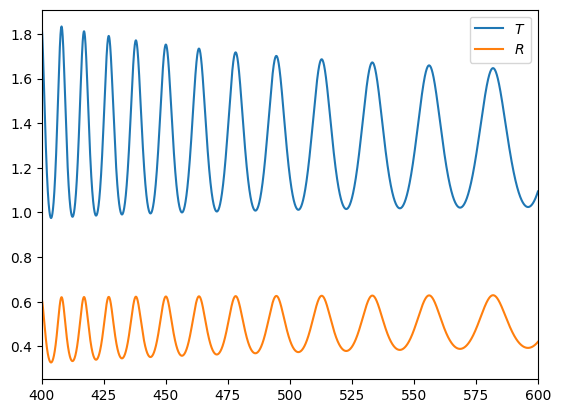

In [189]:
extent = 200
wavelength_center = 450
temp_window = lambda x, y: get_window(x, y, wavelength_center = wavelength_center, extent = extent)
plt.plot(wavelength, T, label = r"$T$")
plt.plot(wavelength, R, label = r"$R$")
plt.xlim([400, 600])
# plt.ylim([0, 0.6])

plt.legend()

In [56]:
t.angle()

AttributeError: 'numpy.ndarray' object has no attribute 'angle'

In [54]:
np.abs(1 + 1j) ** 2

np.float64(2.0000000000000004)

In [52]:
t

array([0.10322593+0.01527634j, 0.04146896+0.00457917j,
       0.04586753+0.00500608j, 0.05020146+0.00541964j,
       0.05446354+0.00581977j, 0.05864853+0.00620649j,
       0.06275279+0.00657993j, 0.06677393+0.0069403j ,
       0.07071048+0.00728785j, 0.07456177+0.00762286j,
       0.07832769+0.00794565j, 0.08200867+0.00825655j,
       0.0856054 +0.00855589j, 0.08911899+0.00884402j,
       0.09255068+0.0091213j , 0.09590194+0.00938807j,
       0.09917431+0.00964466j, 0.10236951+0.00989142j,
       0.10548926+0.01012869j, 0.10853532+0.01035678j,
       0.11150953+0.01057601j, 0.11441372+0.01078669j,
       0.1172497 +0.01098912j, 0.12001926+0.0111836j ,
       0.12272425+0.0113704j , 0.12536639+0.01154979j,
       0.1279474 +0.01172204j, 0.13046907+0.0118874j ,
       0.13293298+0.01204613j, 0.13534081+0.01219845j,
       0.13769415+0.01234459j, 0.13999453+0.01248478j,
       0.14224346+0.01261923j, 0.1444424 +0.01274814j,
       0.14659278+0.01287171j, 0.148696  +0.01299013j,
       0.1

In [47]:
E_0.shape

(500, 2, 1)

In [49]:
E_0_plus.shape

(500,)

In [51]:
t.shape

(500,)

In [42]:
E_k.shape

(2, 1)

In [43]:
M.shape

(500, 2, 2)

In [31]:
T1.shape

(500, 2, 2)

I went into it quite the wrong way. We want to get the transmittance $T$ for every wavelength. There are two ways to do this. Either we go about it the dumb way where we iterate over wavelength values, compute the matrices and then compute T. Either we're a little smarter and we can add a batch dimension to our matrices so that $\mathbf{I}^i$ and $\mathbf{T}^i$ are now matrices of dimensions 
$$
\mathbf{I}^0 
$$

In [ ]:
wavelength=np.linspace(1,1200,500)*u.nanometer
wavelength.to(u.micrometer)

<Quantity [1.00000000e-03, 3.40280561e-03, 5.80561122e-03, 8.20841683e-03,
           1.06112224e-02, 1.30140281e-02, 1.54168337e-02, 1.78196393e-02,
           2.02224449e-02, 2.26252505e-02, 2.50280561e-02, 2.74308617e-02,
           2.98336673e-02, 3.22364729e-02, 3.46392786e-02, 3.70420842e-02,
           3.94448898e-02, 4.18476954e-02, 4.42505010e-02, 4.66533066e-02,
           4.90561122e-02, 5.14589178e-02, 5.38617234e-02, 5.62645291e-02,
           5.86673347e-02, 6.10701403e-02, 6.34729459e-02, 6.58757515e-02,
           6.82785571e-02, 7.06813627e-02, 7.30841683e-02, 7.54869739e-02,
           7.78897796e-02, 8.02925852e-02, 8.26953908e-02, 8.50981964e-02,
           8.75010020e-02, 8.99038076e-02, 9.23066132e-02, 9.47094188e-02,
           9.71122244e-02, 9.95150301e-02, 1.01917836e-01, 1.04320641e-01,
           1.06723447e-01, 1.09126253e-01, 1.11529058e-01, 1.13931864e-01,
           1.16334669e-01, 1.18737475e-01, 1.21140281e-01, 1.23543086e-01,
           1.25945892e-01

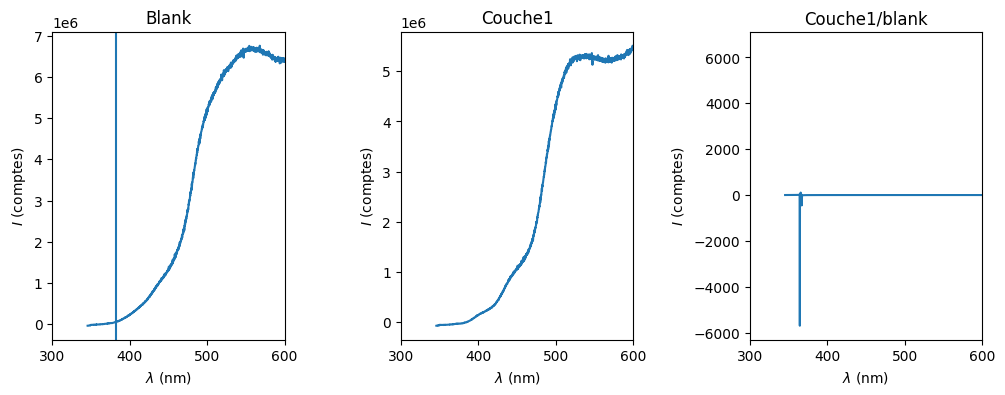

In [193]:
fblank=data_folder+"mince1_d_blank.txt"
fmince=data_folder+"mince1_d.txt"

#writting our file data in the variables

wavelenghtb,intensityb=load_data(fblank)
wavelenght,intensity=load_data(fmince)
ext_stat = 1
wave_stat, int_stat = wavelenghtb[:extent_stat], intensityb[:extent_stat]
offset = int_stat.mean()
#plotting them
xmin=300
xmax=600

fig,axes=plt.subplots(1,3,figsize=(12,4))
ax=axes[0]
ax.plot(wavelenghtb,intensityb-offset)
ax.set(title="Blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])
ax.axvline(wavelenghtb[extent_stat])

ax=axes[1]
ax.plot(wavelenght,intensity-offset)
ax.set(title="Couche1",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])

ax=axes[2]
ax.plot(wavelenght,(intensity - offset)/(intensityb - offset))
ax.set(title="Couche1/blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])



plt.subplots_adjust(wspace=0.5)


In [194]:
offset

np.float64(376180.0653594772)

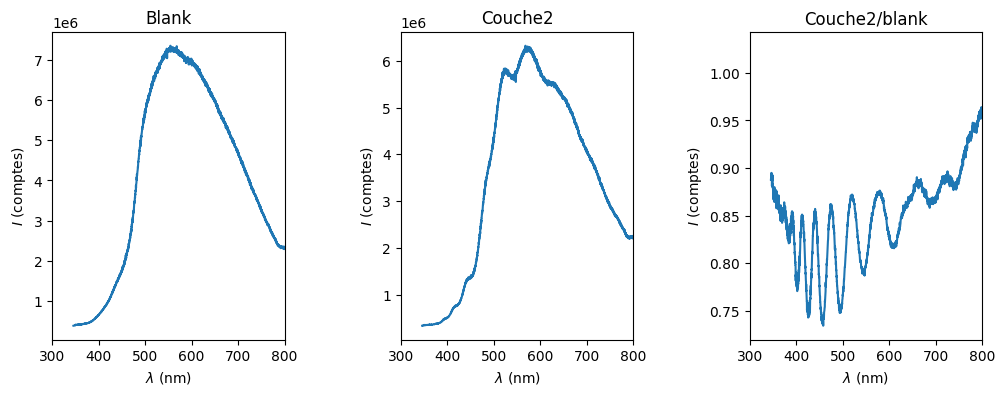

In [ ]:
fblank=data_folder+"mince2_blank.txt"
fmince=data_folder+"mince2_d.txt"

#writting our file data in the variables

wavelenghtb,intensityb=load_data(fblank)
wavelenght,intensity=load_data(fmince)

#plotting them
xmin=300
xmax=800

fig,axes=plt.subplots(1,3,figsize=(12,4))
ax=axes[0]
ax.plot(wavelenghtb,intensityb)
ax.set(title="Blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])

ax=axes[1]
ax.plot(wavelenght,intensity)
ax.set(title="Couche2",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])

ax=axes[2]
ax.plot(wavelenght,intensity/intensityb)
ax.set(title="Couche2/blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])



plt.subplots_adjust(wspace=0.5)

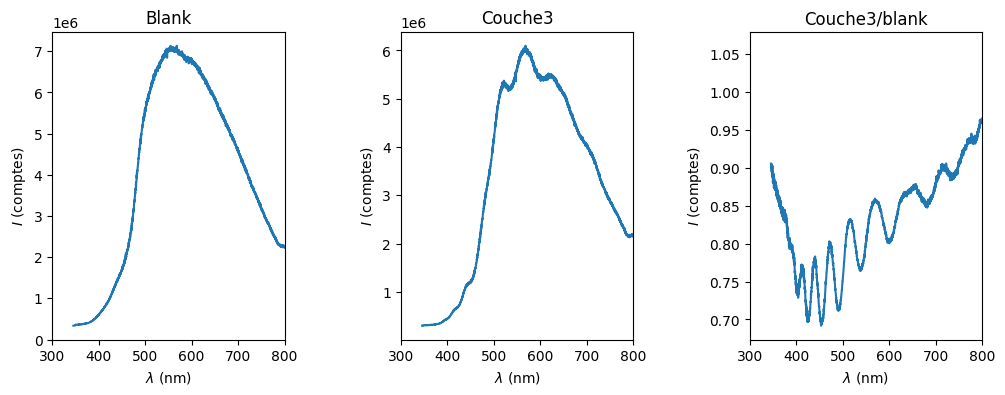

In [102]:
fblank=data_folder+"mince1_d_blank.txt"
fmince=data_folder+"mince3_d.txt"

#writting our file data in the variables

wavelenghtb,intensityb=load_data(fblank)
wavelenght,intensity=load_data(fmince)

#plotting them
xmin=300
xmax=800

fig,axes=plt.subplots(1,3,figsize=(12,4))
ax=axes[0]
ax.plot(wavelenghtb,intensityb)
ax.set(title="Blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])

ax=axes[1]
ax.plot(wavelenght,intensity)
ax.set(title="Couche3",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])

ax=axes[2]
ax.plot(wavelenght,intensity/intensityb)
ax.set(title="Couche3/blank",xlabel=r"$\lambda$ (nm)",ylabel=r"$I$ (comptes)",xlim=[xmin,xmax])



plt.subplots_adjust(wspace=0.5)

In [ ]:
std=params_fitted[1]
mean=params_fitted[0]
fwhm=2*np.sqrt(np.abs(2*np.log(std)))
R=mean/fwhm
R



In [ ]:
ymin

In [ ]:
ymax

In [ ]:
#example of easy fit to learn
def function(x,a=5,b=9):
  return (a*x+b)
x=np.linspace(-5,5,500) #from -5 to 5 with 500 points
a_star,b_star=5,9
data=function(x,a_star,b_star)+np.random.normal(loc=0,scale=1,size=(500,))

plt.plot(x,data,".",label="Data points")
plt.legend()
params_fitted,cov=curve_fit(f=function,xdata=x,ydata=data,sigma=1)


In [ ]:
params_fitted,cov=curve_fit(f=function,xdata=x,ydata=data,sigma=1)
params_fitted

In [ ]:
line=lines[0] #to check if we are doing something wrong in the previous cell
line=line.replace("\t","_")
line=line.replace("\n","_")
line=line.replace(",",".")
ls=line.split("_")
wavelenght=float(ls[0])#we are taking the first column
intensity=float(ls[1])#second column
print(wavelenght,intensity)


How to create a simple figure and save it to our figures folder.

In [ ]:
fig, axs = plt.subplots(1, 1, figsize = (6, 4))

x = np.linspace(-5, 5, 1000) # args = (start, stop, number of points in the array)
x_discrete = np.linspace(-5, 5, 20) # args = (start, stop, number of points in the array)

ax = axs
ax.plot(x, x ** 2, color = 'red', linestyle = 'dashed', label = 'Courbe funky')
ax.errorbar(x_discrete, x_discrete ** 2, fmt = '.', xerr = 2, yerr = 4, color = 'green', label = 'Points de mesure')
ax.set(xlim = (-7, 7), ylim = (-10, 50))
ax.legend()  # Print the legend for the labels in the previous ax.plot instances.

plt.savefig(figure_folder + 'test_figure.pdf', bbox_inches= 'tight') # bbox_inches= 'tight' pour pas avoir de bande blanche autour de l'image

How to open a "*.txt" file.

Note: If the file is 'well-behaved' you can just do np.loadtxt(fname). You might need to put some arguments to this function.

In [ ]:
# Test to open '.txt' file
fname = data_folder + 'blanck_or.txt'
with open(fname, 'r') as f:
  print("WOOOOW")
  lines = f.readlines()
  print(lines)